<a href="https://colab.research.google.com/github/AchmadRaihan/MachineLearningCourses/blob/main/Week%209/Multilayer%20Perceptron/underfit_overfit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install d2l

# Model Selection, Underfitting, and Overfitting


## Polynomial Regression

In [ ]:
import math
import numpy as np
import tensorflow as tf
from d2l import tensorflow as d2l

### Generating the Dataset


In [ ]:
max_degree = 20  # Maximum degree of the polynomial
n_train, n_test = 100, 100  # Training and test dataset sizes
true_w = np.zeros(max_degree)  # Allocate lots of empty space
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# Shape of `labels`: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [ ]:
# Convert from NumPy ndarrays to tensors
true_w, features, poly_features, labels = [tf.constant(x, dtype=
    tf.float32) for x in [true_w, features, poly_features, labels]]

In [ ]:
features[:2], poly_features[:2, :], labels[:2]

(<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[-0.49510553],
        [-0.18967132]], dtype=float32)>,
 <tf.Tensor: shape=(2, 20), dtype=float32, numpy=
 array([[ 1.0000000e+00, -4.9510553e-01,  1.2256475e-01, -2.0227496e-02,
          2.5036864e-03, -2.4791778e-04,  2.0457579e-05, -1.4469515e-06,
          8.9549218e-08, -4.9262567e-09,  2.4390170e-10, -1.0977917e-11,
          4.5293565e-13, -1.7250073e-14,  6.1004335e-16, -2.0135722e-17,
          6.2308171e-19, -1.8146543e-20,  4.9913630e-22, -1.3006587e-23],
        [ 1.0000000e+00, -1.8967132e-01,  1.7987607e-02, -1.1372444e-03,
          5.3925662e-05, -2.0456305e-06,  6.4666239e-08, -1.7521903e-09,
          4.1542530e-11, -8.7549190e-13,  1.6605571e-14, -2.8632734e-16,
          4.5256739e-18, -6.6030041e-20,  8.9457190e-22, -1.1311642e-23,
          1.3409339e-25, -1.4960983e-27,  1.5764830e-29, -1.5737560e-31]],
       dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([3.8692272, 4.814366 ], dtyp

### Training and Testing the Model

**Implement a function to evaluate the loss on a given dataset**


In [ ]:
def evaluate_loss(net, data_iter, loss):  #@save
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        l = loss(net(X), y)
        metric.add(tf.reduce_sum(l), d2l.size(l))
    return metric[0] / metric[1]

**Define the training function**

In [ ]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = tf.losses.MeanSquaredError()
    input_shape = train_features.shape[-1]
    # Switch off the bias since we already catered for it in the polynomial
    # features
    net = tf.keras.Sequential()
    net.add(tf.keras.layers.Dense(1, use_bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    test_iter = d2l.load_array((test_features, test_labels), batch_size,
                               is_train=False)
    trainer = tf.keras.optimizers.SGD(learning_rate=.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net.get_weights()[0].T)

### [**Third-Order Polynomial Function Fitting (Normal)**]


weight: [[ 5.0229588  1.1948187 -3.4082928  5.6184235]]


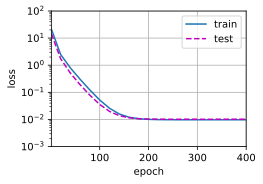

In [ ]:
# Pick the first four dimensions, i.e., 1, x, x^2/2!, x^3/3! from the
# polynomial features
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

### [**Linear Function Fitting (Underfitting)**]


weight: [[3.2146964 3.7592108]]


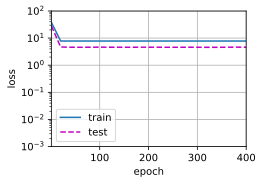

In [ ]:
# Pick the first two dimensions, i.e., 1, x, from the polynomial features
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

### [**Higher-Order Polynomial Function Fitting  (Overfitting)**]

weight: [[ 4.987903    1.2853208  -3.2547188   5.2147574  -0.4877339   1.1133145
   0.53465724 -0.23518935  0.3390382  -0.42560643  0.09675226 -0.11365952
  -0.20155556 -0.39643663 -0.07667527  0.3524657  -0.3036194  -0.4453125
   0.35559314 -0.09181255]]


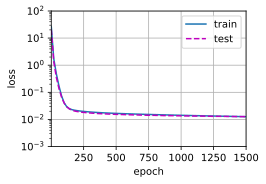

In [ ]:
# Pick all the dimensions from the polynomial features
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)